In [1]:
from training_functions import *
from merging import *
from utils import *
from model_evaluation import ModelEvaluation
import pandas as pd

2024-09-04 23:37:38.288589: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 23:37:39.215401: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def join_data_and_preds_exp(
    df_preds_full_mp: pd.DataFrame,
    df_data_exp_mp: pd.DataFrame,
) -> pd.DataFrame:
    df_preds_mp_exp = df_preds_full_mp.set_index("material_id").loc[df_data_exp_mp["mp"]].reset_index().copy()
    df_preds_mp_exp[["sigma_S_cm", "Ea", "icsd"]] = df_data_exp_mp[["σ(RT)(S cm-1)", "Ea (eV)", "icsd"]]
    df_preds_mp_exp = df_preds_mp_exp.join(
        1.0 / df_preds_mp_exp.groupby("material_id").size().rename("sample_weight"),
        on="material_id",
    )
    return df_preds_mp_exp


In [3]:
preds_mp = pd.read_csv("datasets/exported.predictions.mp.v2.csv")
ref_mp = pd.read_csv("datasets/mp_Laskowski2023_map.csv")

preds_mp_exp = join_data_and_preds_exp(
    df_preds_full_mp=preds_mp,
    df_data_exp_mp=ref_mp,
)

preds_icsd_exp = join_data_and_preds_icsd(
    df_preds_icsd=pd.read_csv("datasets/exported.predictions.icsd.v3.csv"),
    df_data_exp_full=pd.read_csv("datasets/digitized_data_for_SSEs.csv"),
)

preds_mp_exp = pd.concat([preds_mp_exp, preds_icsd_exp], axis=0).reset_index(drop=True)


In [4]:
df_kahle_fin_nn = get_nn_features_kahle()

X_kahle_nn = df_kahle_fin_nn.drop([ 
    'src_id',
    'diffusion_mean_cm2_s',
    'stru_label', 
    'stru_id', 
    'structure', 
    'group', 
    'label', 
    'diffusion_sem_cm2_s', 
    'n_Li', 
    'sigma_S_cm', 
    'sigma_S_cm_sem', 
    'sigma_S_cm_err',
 ], axis=1)

df_mpdb_nn = get_nn_features_mpdb()

X_mpdb_nn = df_mpdb_nn.drop([ 
    'material_id',
 ], axis=1)

In [5]:
df_mp_exp = get_nn_features_exp()

X_exp_nn = df_mp_exp.drop(['material_id', 'sigma_S_cm', 'icsd', 'sample_weight'], axis = 1)


In [6]:
feature_names_nn = X_kahle_nn.columns.tolist()
feature_names_nn = np.array(feature_names_nn)

X_kahle_nn = X_kahle_nn.to_numpy()
X_mpdb_nn = X_mpdb_nn.to_numpy()
X_exp_nn = X_exp_nn.to_numpy()

scaler = StandardScaler().fit(X_mpdb_nn)

X_mpdb_nn = scaler.transform(X_mpdb_nn)
X_kahle_nn = scaler.transform(X_kahle_nn)
X_exp_nn = scaler.transform(X_exp_nn)

cnt_and_name_features_nn = {
    'robust': 3,
    'connected': 16,
    'disconnected': 16
    }

feature_weights_nn = [1 / cnt_and_name_features_nn[(x.split('_')[-2])] for x in feature_names_nn]

In [7]:
from misc_utils import augment_Kahle2020
from misc_utils import augment_preds

df_Kahle2020 = augment_Kahle2020.read_and_augment(
    "data_slim.csv",
)

preds_Kahle2020 = augment_preds.join_data_and_preds_Kahle2020(
    df_preds=pd.read_csv("datasets/exported.predictions.Kahle2020.v2.csv"),
    df_data=df_Kahle2020,
)

preds_mp = pd.read_csv("datasets/exported.predictions.mp.v2.csv")
ref_mp = pd.read_csv("datasets/mp_Laskowski2023_map.csv")

preds_mp_exp = join_data_and_preds_exp(
    df_preds_full_mp=preds_mp,
    df_data_exp_mp=ref_mp,
)

preds_icsd_exp = join_data_and_preds_icsd(
    df_preds_icsd=pd.read_csv("datasets/exported.predictions.icsd.v3.csv"),
    df_data_exp_full=pd.read_csv("datasets/digitized_data_for_SSEs.csv"),
)

preds_mp_exp = pd.concat([preds_mp_exp, preds_icsd_exp], axis=0).reset_index(drop=True)
preds_mp_exp = join_data_and_preds_exp(
    df_preds_full_mp=preds_mp,
    df_data_exp_mp=ref_mp,
)[['material_id']]

df_mpdb_plane, cnt_and_name_features_mpdb = get_featurizers_features_mpdb()
preds_mp_exp = preds_mp_exp.merge(df_mpdb_plane, on = 'material_id')

df_icsd_exp, cnt_and_name_features_icsd = get_featurizers_features_exp()

assert df_icsd_exp['icsd'].to_list() == preds_icsd_exp['icsd'].to_list()

df_icsd_exp = df_icsd_exp.drop(['icdd_pdf', 'icsd'], axis = 1)
preds_mp_exp = preds_mp_exp.drop(['formula_pretty', 'material_id'], axis = 1)

preds_mp_exp = pd.concat([preds_mp_exp, df_icsd_exp], axis=0).reset_index(drop=True)




df_mpdb_plane, cnt_and_name_features_mpdb = get_featurizers_features_mpdb()

X_mpdb = df_mpdb_plane.drop([ 
     'formula_pretty',
     'material_id', 
 ], axis=1)

df_kahle_fin, cnt_and_name_features_kahle = get_featurizers_features_kahle()

X_kahle = df_kahle_fin.drop([ 
    'stru_label',
     'stru_id', 
     'group', 
     'structure', 
     'diffusion_mean_cm2_s', 
     'label', 
     'src_id', 
     'diffusion_sem_cm2_s', 
     'n_Li', 
     'sigma_S_cm', 
     'sigma_S_cm_sem', 
     'sigma_S_cm_err'
 ], axis=1)


feature_names = X_kahle.columns.tolist()
feature_names = np.array(feature_names)[~np.all(X_kahle.to_numpy() == 0, axis=0)]

X_kahle = X_kahle.to_numpy()
X_mpdb = X_mpdb.to_numpy()
X_exp = preds_mp_exp.to_numpy()

X_mpdb = X_mpdb[:, ~np.all(X_kahle == 0, axis=0)]
X_exp = X_exp[:, ~np.all(X_kahle == 0, axis=0)]

X_kahle = X_kahle[:, ~np.all(X_kahle == 0, axis=0)]

scaler = StandardScaler()

X_mpdb = scaler.fit_transform(X_mpdb)
X_exp = scaler.transform(X_exp)
X_kahle = scaler.transform(X_kahle)


feature_weights = [1 / cnt_and_name_features_kahle['_'.join(x.split('_')[1:])] for x in feature_names]
feature_names = np.array(list(map(lambda x: x.split('_')[0] + '_' + featurizers_mapping['_'.join(x.split('_')[1:])], feature_names)))

Estimating lognorm D parameters


Making initial guess:   0%|          | 0/195 [00:00<?, ?it/s]

2024-09-04 23:38:05.034410: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21041 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:06:00.0, compute capability: 8.6
2024-09-04 23:38:05.034993: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 8944 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:0a:00.0, compute capability: 7.5
2024-09-04 23:38:05.035451: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9836 MB memory:  -> device: 2, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1


refining:   0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
print(X_exp.shape, X_exp_nn.shape)

(144, 2253) (144, 35)


In [9]:
X_exp_merged = np.concatenate([X_exp, X_exp_nn], axis=1)
X_kahle_merged = np.concatenate([X_kahle, X_kahle_nn], axis=1)
X_mpdb_merged = np.concatenate([X_mpdb, X_mpdb_nn], axis=1)

In [10]:
feature_names_merged = np.concatenate([feature_names, feature_names_nn], axis = 0)
feature_weights_merged = np.concatenate([feature_weights, feature_weights_nn], axis = 0)

In [11]:
params = {
        "max_iter": 300,
        "C": 1.51188643e-03
    }

pipeline_logreg_l2 = ModelEvaluation(df_kahle_fin, preds_Kahle2020, model_name = 'logreg', params = params)
pipeline_logreg_l2.fit(X_kahle_merged, feature_weights_merged, thr_positive = 1e-1, thr_negative = 1e-2, threshold = 1e-2, feature_names = feature_names_merged)
pipeline_logreg_l2.evaluate(num_of_evaluations = 20, X_mpdb = X_mpdb_merged, X_exp = X_exp_merged)
pipeline_logreg_l2.get_aggregated_statistics()

  0%|          | 0/20 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.9052255761116521
test roc-auc mean: 0.7357720422244008, std: 0.06145838183386169
mean train roc-auc: 0.9066456469338744


  0%|          | 0/1000 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:12<04:00, 12.64s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 10%|█         | 2/20 [00:24<03:40, 12.23s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 15%|█▌        | 3/20 [00:36<03:26, 12.15s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 20%|██        | 4/20 [00:48<03:15, 12.20s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 25%|██▌       | 5/20 [01:00<03:01, 12.10s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 30%|███       | 6/20 [01:12<02:49, 12.12s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [01:24<02:37, 12.08s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 40%|████      | 8/20 [01:38<02:29, 12.45s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [01:50<02:17, 12.54s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 10/20 [02:03<02:05, 12.54s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [02:16<01:54, 12.72s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 60%|██████    | 12/20 [02:28<01:38, 12.37s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [02:40<01:26, 12.39s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 70%|███████   | 14/20 [02:53<01:15, 12.51s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [03:05<01:01, 12.26s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 80%|████████  | 16/20 [03:17<00:48, 12.18s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [03:29<00:36, 12.14s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 90%|█████████ | 18/20 [03:41<00:24, 12.13s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 95%|█████████▌| 19/20 [03:53<00:12, 12.20s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 20/20 [04:05<00:00, 12.29s/it]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
pipeline_logreg_l2.show_results()

,statistic,result
0,mean train roc-auc averaged by 40 models,9.066456e-01
1,roc_auc on test by aggregated preds,7.345992e-01
2,mean test roc-auc averaged by 40 models,7.350544e-01
3,roc_like_comparison by aggregated preds,7.507050e+01
4,roc_like_comparison averaged by 40 models,7.507050e+01
5,roc_like_comparison std,1.421085e-14


In [13]:
c

|    | statistic                                 |       result |
|---:|:------------------------------------------|-------------:|
|  0 | mean train roc-auc averaged by 40 models  |  0.906646    |
|  1 | roc_auc on test by aggregated preds       |  0.734599    |
|  2 | mean test roc-auc averaged by 40 models   |  0.735054    |
|  3 | roc_like_comparison by aggregated preds   | 75.0705      |
|  4 | roc_like_comparison averaged by 40 models | 75.0705      |
|  5 | roc_like_comparison std                   |  1.42109e-14 |


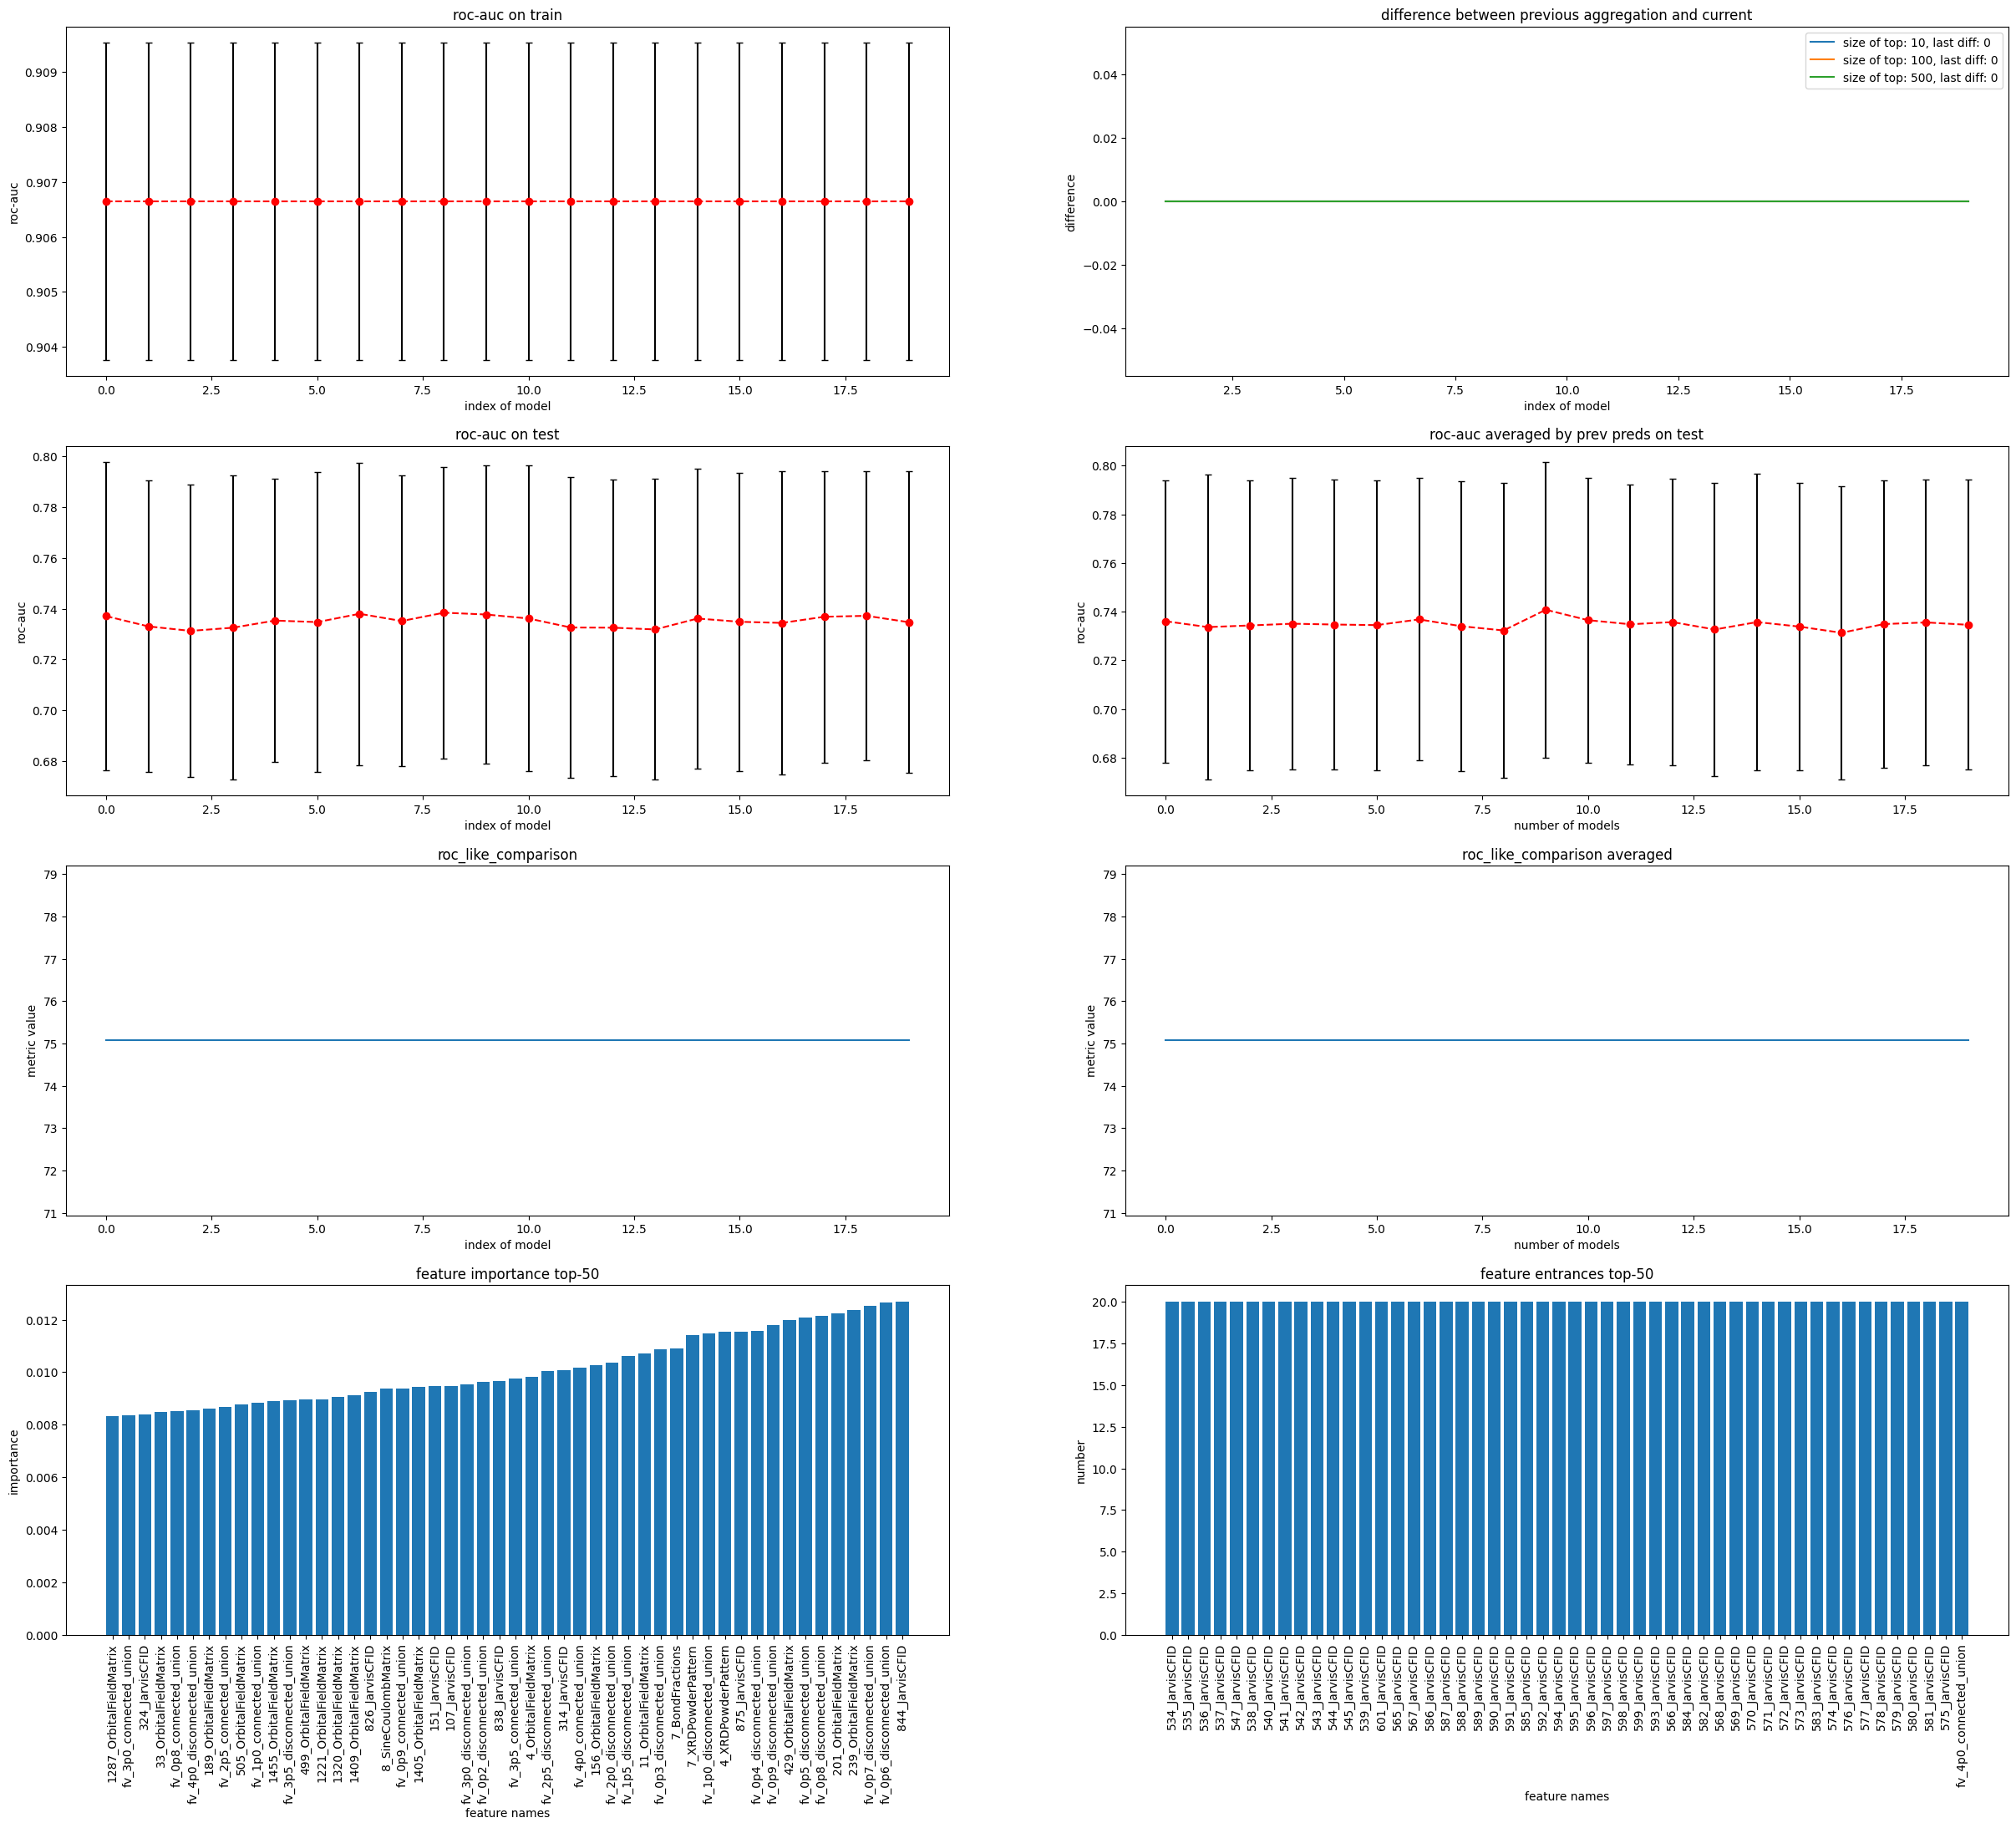

In [14]:
pipeline_logreg_l2.plot_statistics()

In [15]:
preds_logreg_l2_kahle = pipeline_logreg_l2.preds_kahle_averaged[-1]
preds_logreg_l2_mpdb = pipeline_logreg_l2.preds_mpdb_averaged[-1]
preds_logreg_l2_exp = pipeline_logreg_l2.preds_exp_averaged[-1]

np.save('predictions/merged_logreg_l2_kahle.npy', preds_logreg_l2_kahle)
np.save('predictions/merged_logreg_l2_mpdb.npy', preds_logreg_l2_mpdb)
np.save('predictions/merged_logreg_l2_exp.npy', preds_logreg_l2_exp)


In [17]:
import warnings
warnings.filterwarnings("ignore")

params = {
        "max_iter": 300,
        "penalty": "l1",
        "solver": "saga",
        "C": 0.2
    }


pipeline_logreg_l1 = ModelEvaluation(df_kahle_fin, preds_Kahle2020, model_name = 'logreg', params = params)
pipeline_logreg_l1.fit(X_kahle_merged, feature_weights_merged, thr_positive = 1e-1, thr_negative = 1e-2, threshold = 1e-2, feature_names = feature_names_merged)
pipeline_logreg_l1.evaluate(num_of_evaluations = 20, X_mpdb = X_mpdb_merged, X_exp = X_exp_merged)
pipeline_logreg_l1.get_aggregated_statistics()

  0%|          | 0/20 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.900519311911717
test roc-auc mean: 0.7639649024037417, std: 0.05730809710653073
mean train roc-auc: 0.9024502660803496


  0%|          | 0/1000 [00:00<?, ?it/s]

  5%|▌         | 1/20 [02:45<52:21, 165.34s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 10%|█         | 2/20 [05:32<49:58, 166.57s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 15%|█▌        | 3/20 [08:19<47:09, 166.42s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 20%|██        | 4/20 [11:02<44:05, 165.37s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 25%|██▌       | 5/20 [13:48<41:22, 165.48s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 30%|███       | 6/20 [16:35<38:45, 166.09s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [19:22<36:03, 166.41s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 40%|████      | 8/20 [22:09<33:16, 166.40s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [24:56<30:33, 166.72s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 10/20 [27:42<27:44, 166.46s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [30:27<24:54, 166.02s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 60%|██████    | 12/20 [33:12<22:04, 165.61s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [35:57<19:19, 165.64s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 70%|███████   | 14/20 [38:45<16:38, 166.34s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [41:32<13:52, 166.59s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 80%|████████  | 16/20 [44:19<11:06, 166.52s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [47:08<08:21, 167.18s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 90%|█████████ | 18/20 [49:55<05:34, 167.26s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 95%|█████████▌| 19/20 [52:40<02:46, 166.58s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 20/20 [55:26<00:00, 166.32s/it]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
pipeline_logreg_l1.show_results()

,statistic,result
0,mean train roc-auc averaged by 40 models,0.902451
1,roc_auc on test by aggregated preds,0.762358
2,mean test roc-auc averaged by 40 models,0.761284
3,roc_like_comparison by aggregated preds,95.297226
4,roc_like_comparison averaged by 40 models,95.218938
5,roc_like_comparison std,0.156577


In [19]:
print(pipeline_logreg_l1.show_results().to_markdown())

|    | statistic                                 |    result |
|---:|:------------------------------------------|----------:|
|  0 | mean train roc-auc averaged by 40 models  |  0.902451 |
|  1 | roc_auc on test by aggregated preds       |  0.762358 |
|  2 | mean test roc-auc averaged by 40 models   |  0.761284 |
|  3 | roc_like_comparison by aggregated preds   | 95.2972   |
|  4 | roc_like_comparison averaged by 40 models | 95.2189   |
|  5 | roc_like_comparison std                   |  0.156577 |


In [20]:
preds_logreg_l1_kahle = pipeline_logreg_l1.preds_kahle_averaged[-1]
preds_logreg_l1_mpdb = pipeline_logreg_l1.preds_mpdb_averaged[-1]
preds_logreg_l1_exp = pipeline_logreg_l1.preds_exp_averaged[-1]

np.save('predictions/merged_logreg_l1_kahle.npy', preds_logreg_l1_kahle)
np.save('predictions/merged_logreg_l1_mpdb.npy', preds_logreg_l1_mpdb)
np.save('predictions/merged_logreg_l1_exp.npy', preds_logreg_l1_exp)


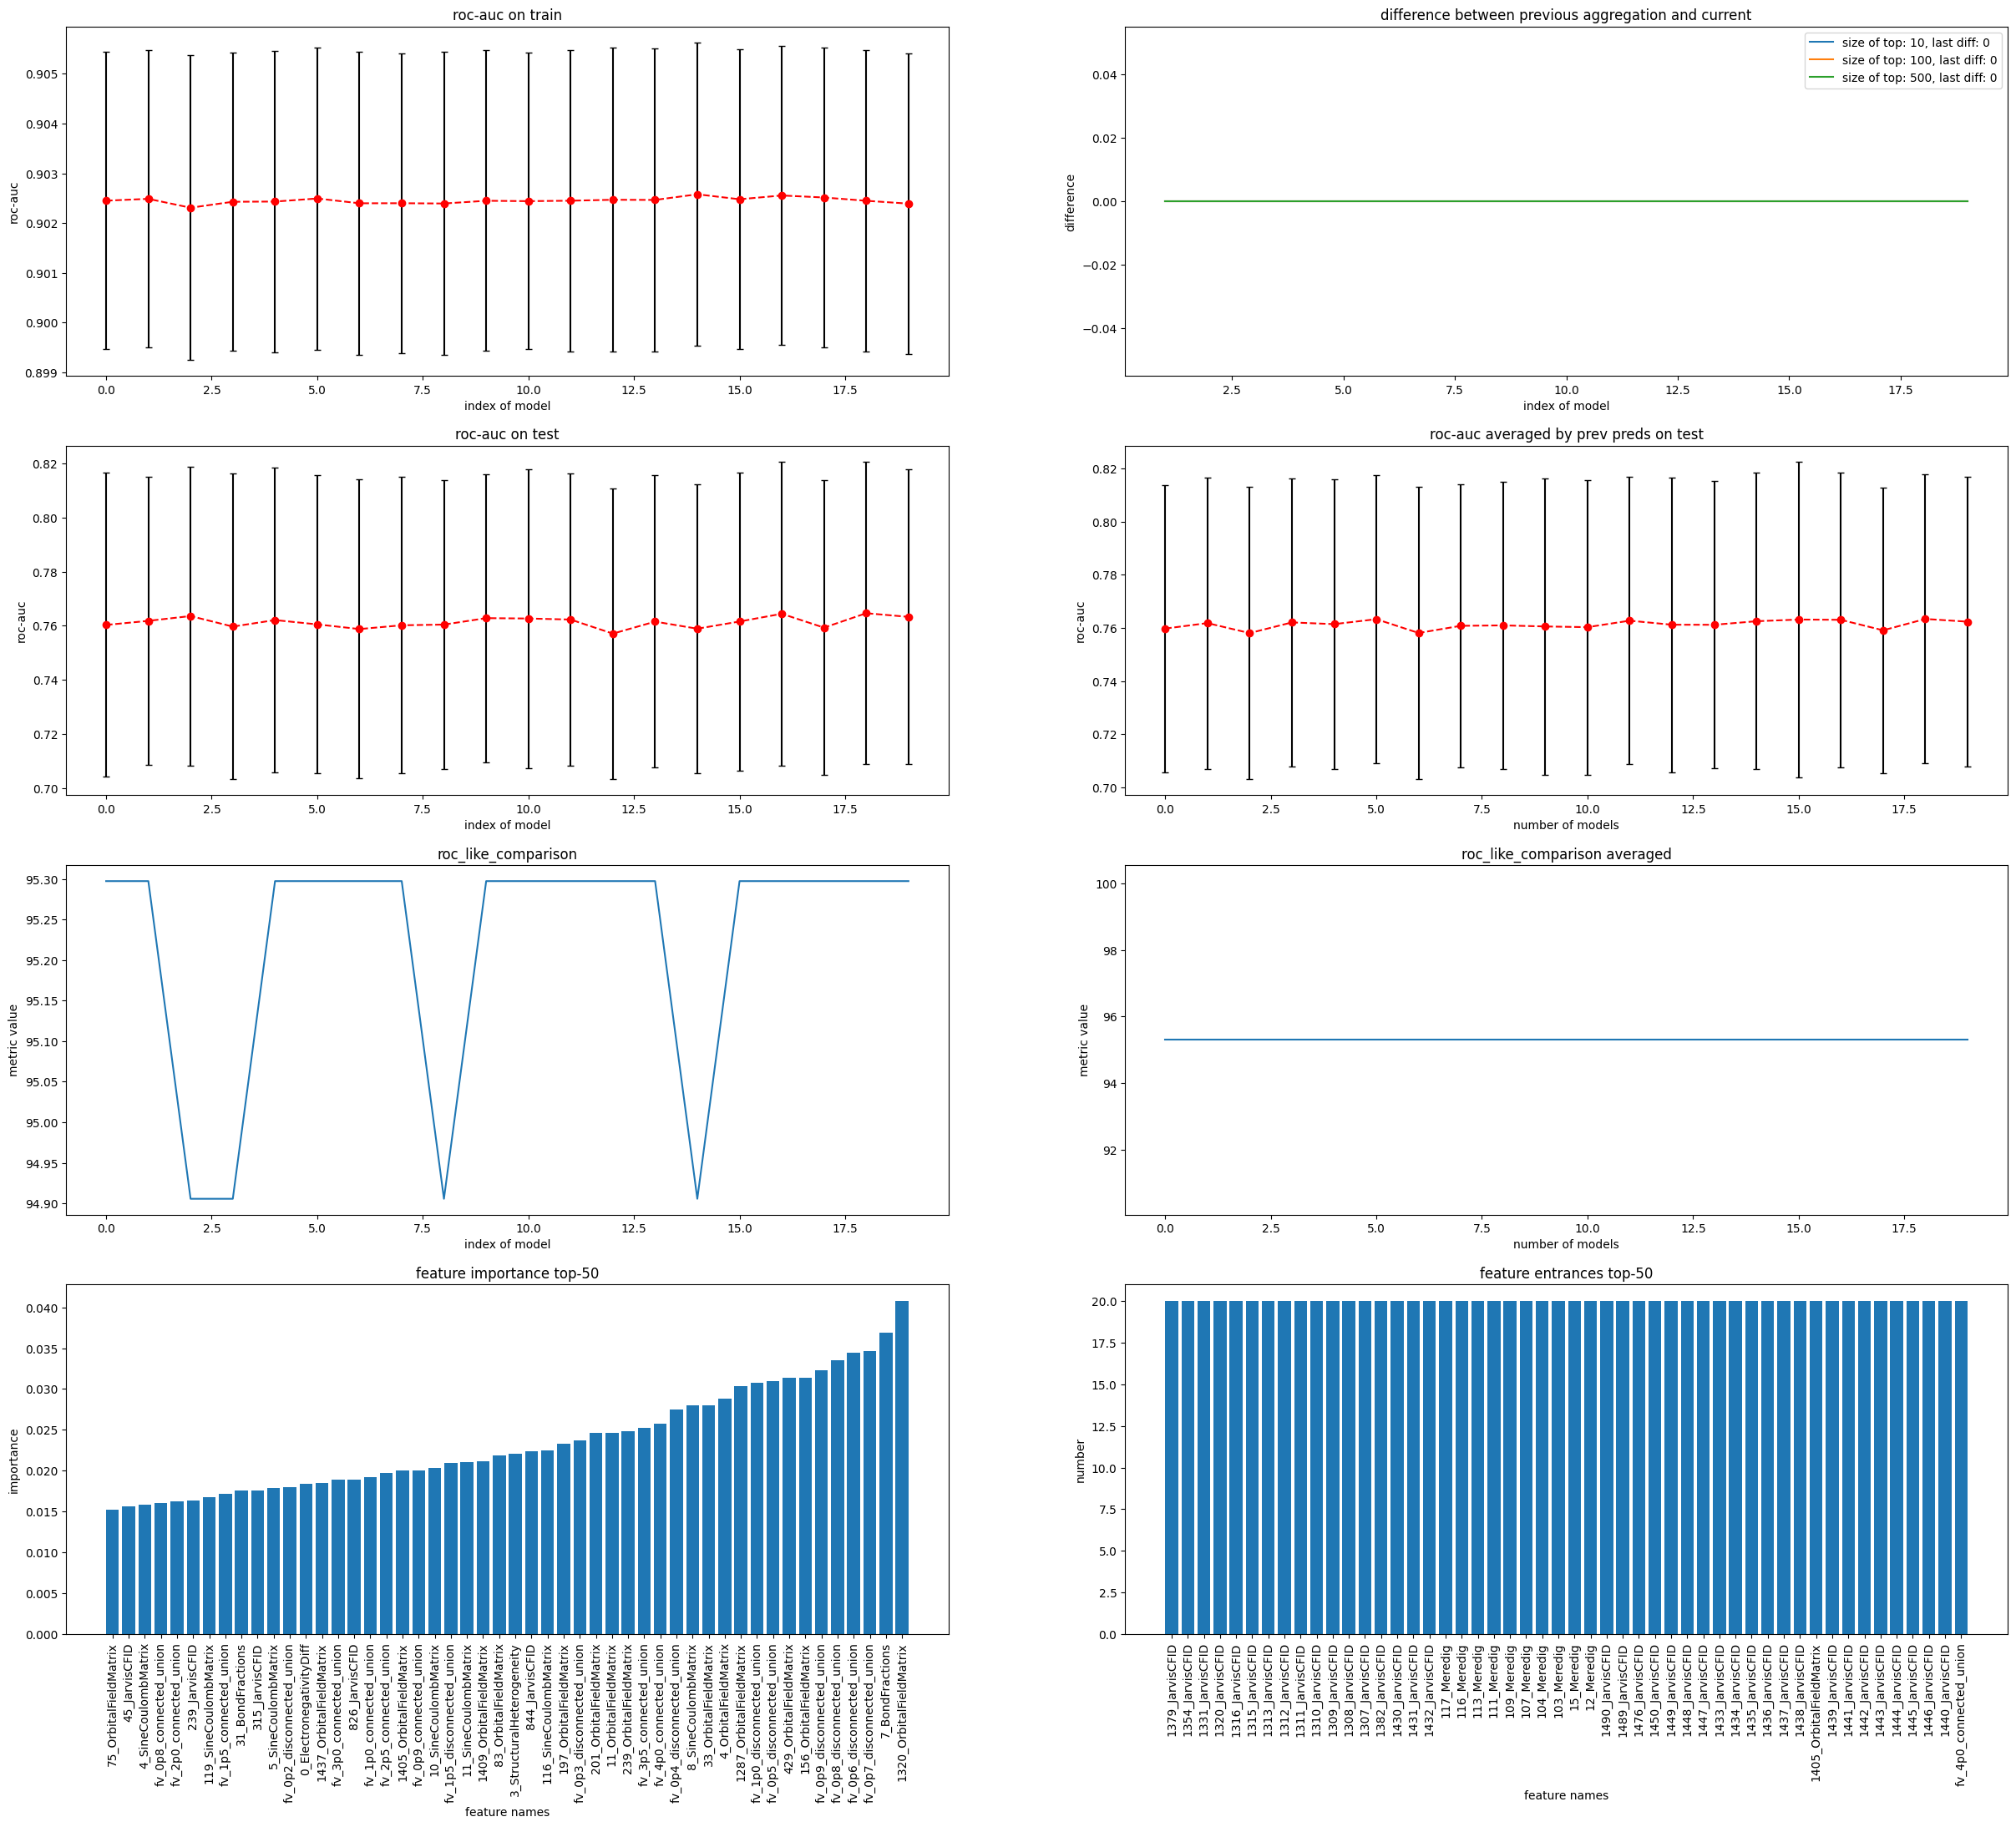

In [21]:
pipeline_logreg_l1.plot_statistics()

In [23]:
params = {
        "max_depth": 2,
        "learning_rate" : 0.1,
        "iterations": 40,
    }

pipeline_catboost = ModelEvaluation(df_kahle_fin, preds_Kahle2020, model_name = 'catboost', params = params)
pipeline_catboost.fit(X_kahle, feature_weights, thr_positive = 1e-1, thr_negative = 1e-2, threshold = 1e-2, feature_names = feature_names)
pipeline_catboost.evaluate(num_of_evaluations = 40, X_mpdb = X_mpdb, X_exp = X_exp)
pipeline_catboost.get_aggregated_statistics()

  0%|          | 0/40 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.9162609542356378
test roc-auc mean: 0.7158233672672454, std: 0.056391379319365276
mean train roc-auc: 0.9037662621838904


  0%|          | 0/1000 [00:00<?, ?it/s]

  2%|▎         | 1/40 [01:10<45:44, 70.36s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

  5%|▌         | 2/40 [02:20<44:35, 70.41s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

  8%|▊         | 3/40 [03:31<43:21, 70.31s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 10%|█         | 4/40 [04:40<42:05, 70.16s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 12%|█▎        | 5/40 [05:49<40:38, 69.66s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 15%|█▌        | 6/40 [06:59<39:26, 69.60s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 18%|█▊        | 7/40 [08:07<38:06, 69.28s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 20%|██        | 8/40 [09:16<36:54, 69.22s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 22%|██▎       | 9/40 [10:26<35:47, 69.27s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 25%|██▌       | 10/40 [11:36<34:43, 69.44s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 28%|██▊       | 11/40 [12:46<33:41, 69.69s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 30%|███       | 12/40 [13:56<32:37, 69.91s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 32%|███▎      | 13/40 [15:06<31:27, 69.92s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 35%|███▌      | 14/40 [16:15<30:10, 69.64s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 38%|███▊      | 15/40 [17:25<28:58, 69.54s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 40%|████      | 16/40 [18:34<27:46, 69.42s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 42%|████▎     | 17/40 [19:43<26:35, 69.38s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 45%|████▌     | 18/40 [20:53<25:28, 69.46s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 48%|████▊     | 19/40 [22:03<24:22, 69.62s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 20/40 [23:13<23:14, 69.74s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 52%|█████▎    | 21/40 [24:23<22:08, 69.90s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 55%|█████▌    | 22/40 [25:32<20:53, 69.61s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 57%|█████▊    | 23/40 [26:42<19:44, 69.67s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 60%|██████    | 24/40 [27:51<18:33, 69.57s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 62%|██████▎   | 25/40 [29:00<17:21, 69.43s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 65%|██████▌   | 26/40 [30:09<16:11, 69.41s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 68%|██████▊   | 27/40 [31:20<15:05, 69.66s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 70%|███████   | 28/40 [32:30<13:59, 69.93s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 72%|███████▎  | 29/40 [33:40<12:49, 69.97s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 75%|███████▌  | 30/40 [34:51<11:40, 70.08s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 78%|███████▊  | 31/40 [36:00<10:29, 69.98s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 80%|████████  | 32/40 [37:08<09:14, 69.35s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 82%|████████▎ | 33/40 [38:17<08:04, 69.23s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 85%|████████▌ | 34/40 [39:27<06:57, 69.55s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 88%|████████▊ | 35/40 [40:36<05:45, 69.15s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 90%|█████████ | 36/40 [41:44<04:35, 68.83s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 92%|█████████▎| 37/40 [42:53<03:26, 68.85s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 95%|█████████▌| 38/40 [44:01<02:17, 68.62s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 98%|█████████▊| 39/40 [45:11<01:09, 69.02s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 40/40 [46:21<00:00, 69.54s/it]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [24]:
pipeline_catboost.show_results()

,statistic,result
0,mean train roc-auc averaged by 40 models,0.902077
1,roc_auc on test by aggregated preds,0.724485
2,mean test roc-auc averaged by 40 models,0.720799
3,roc_like_comparison by aggregated preds,66.882845
4,roc_like_comparison averaged by 40 models,64.689482
5,roc_like_comparison std,6.646973


In [25]:
print(pipeline_catboost.show_results().to_markdown())

|    | statistic                                 |    result |
|---:|:------------------------------------------|----------:|
|  0 | mean train roc-auc averaged by 40 models  |  0.902077 |
|  1 | roc_auc on test by aggregated preds       |  0.724485 |
|  2 | mean test roc-auc averaged by 40 models   |  0.720799 |
|  3 | roc_like_comparison by aggregated preds   | 66.8828   |
|  4 | roc_like_comparison averaged by 40 models | 64.6895   |
|  5 | roc_like_comparison std                   |  6.64697  |


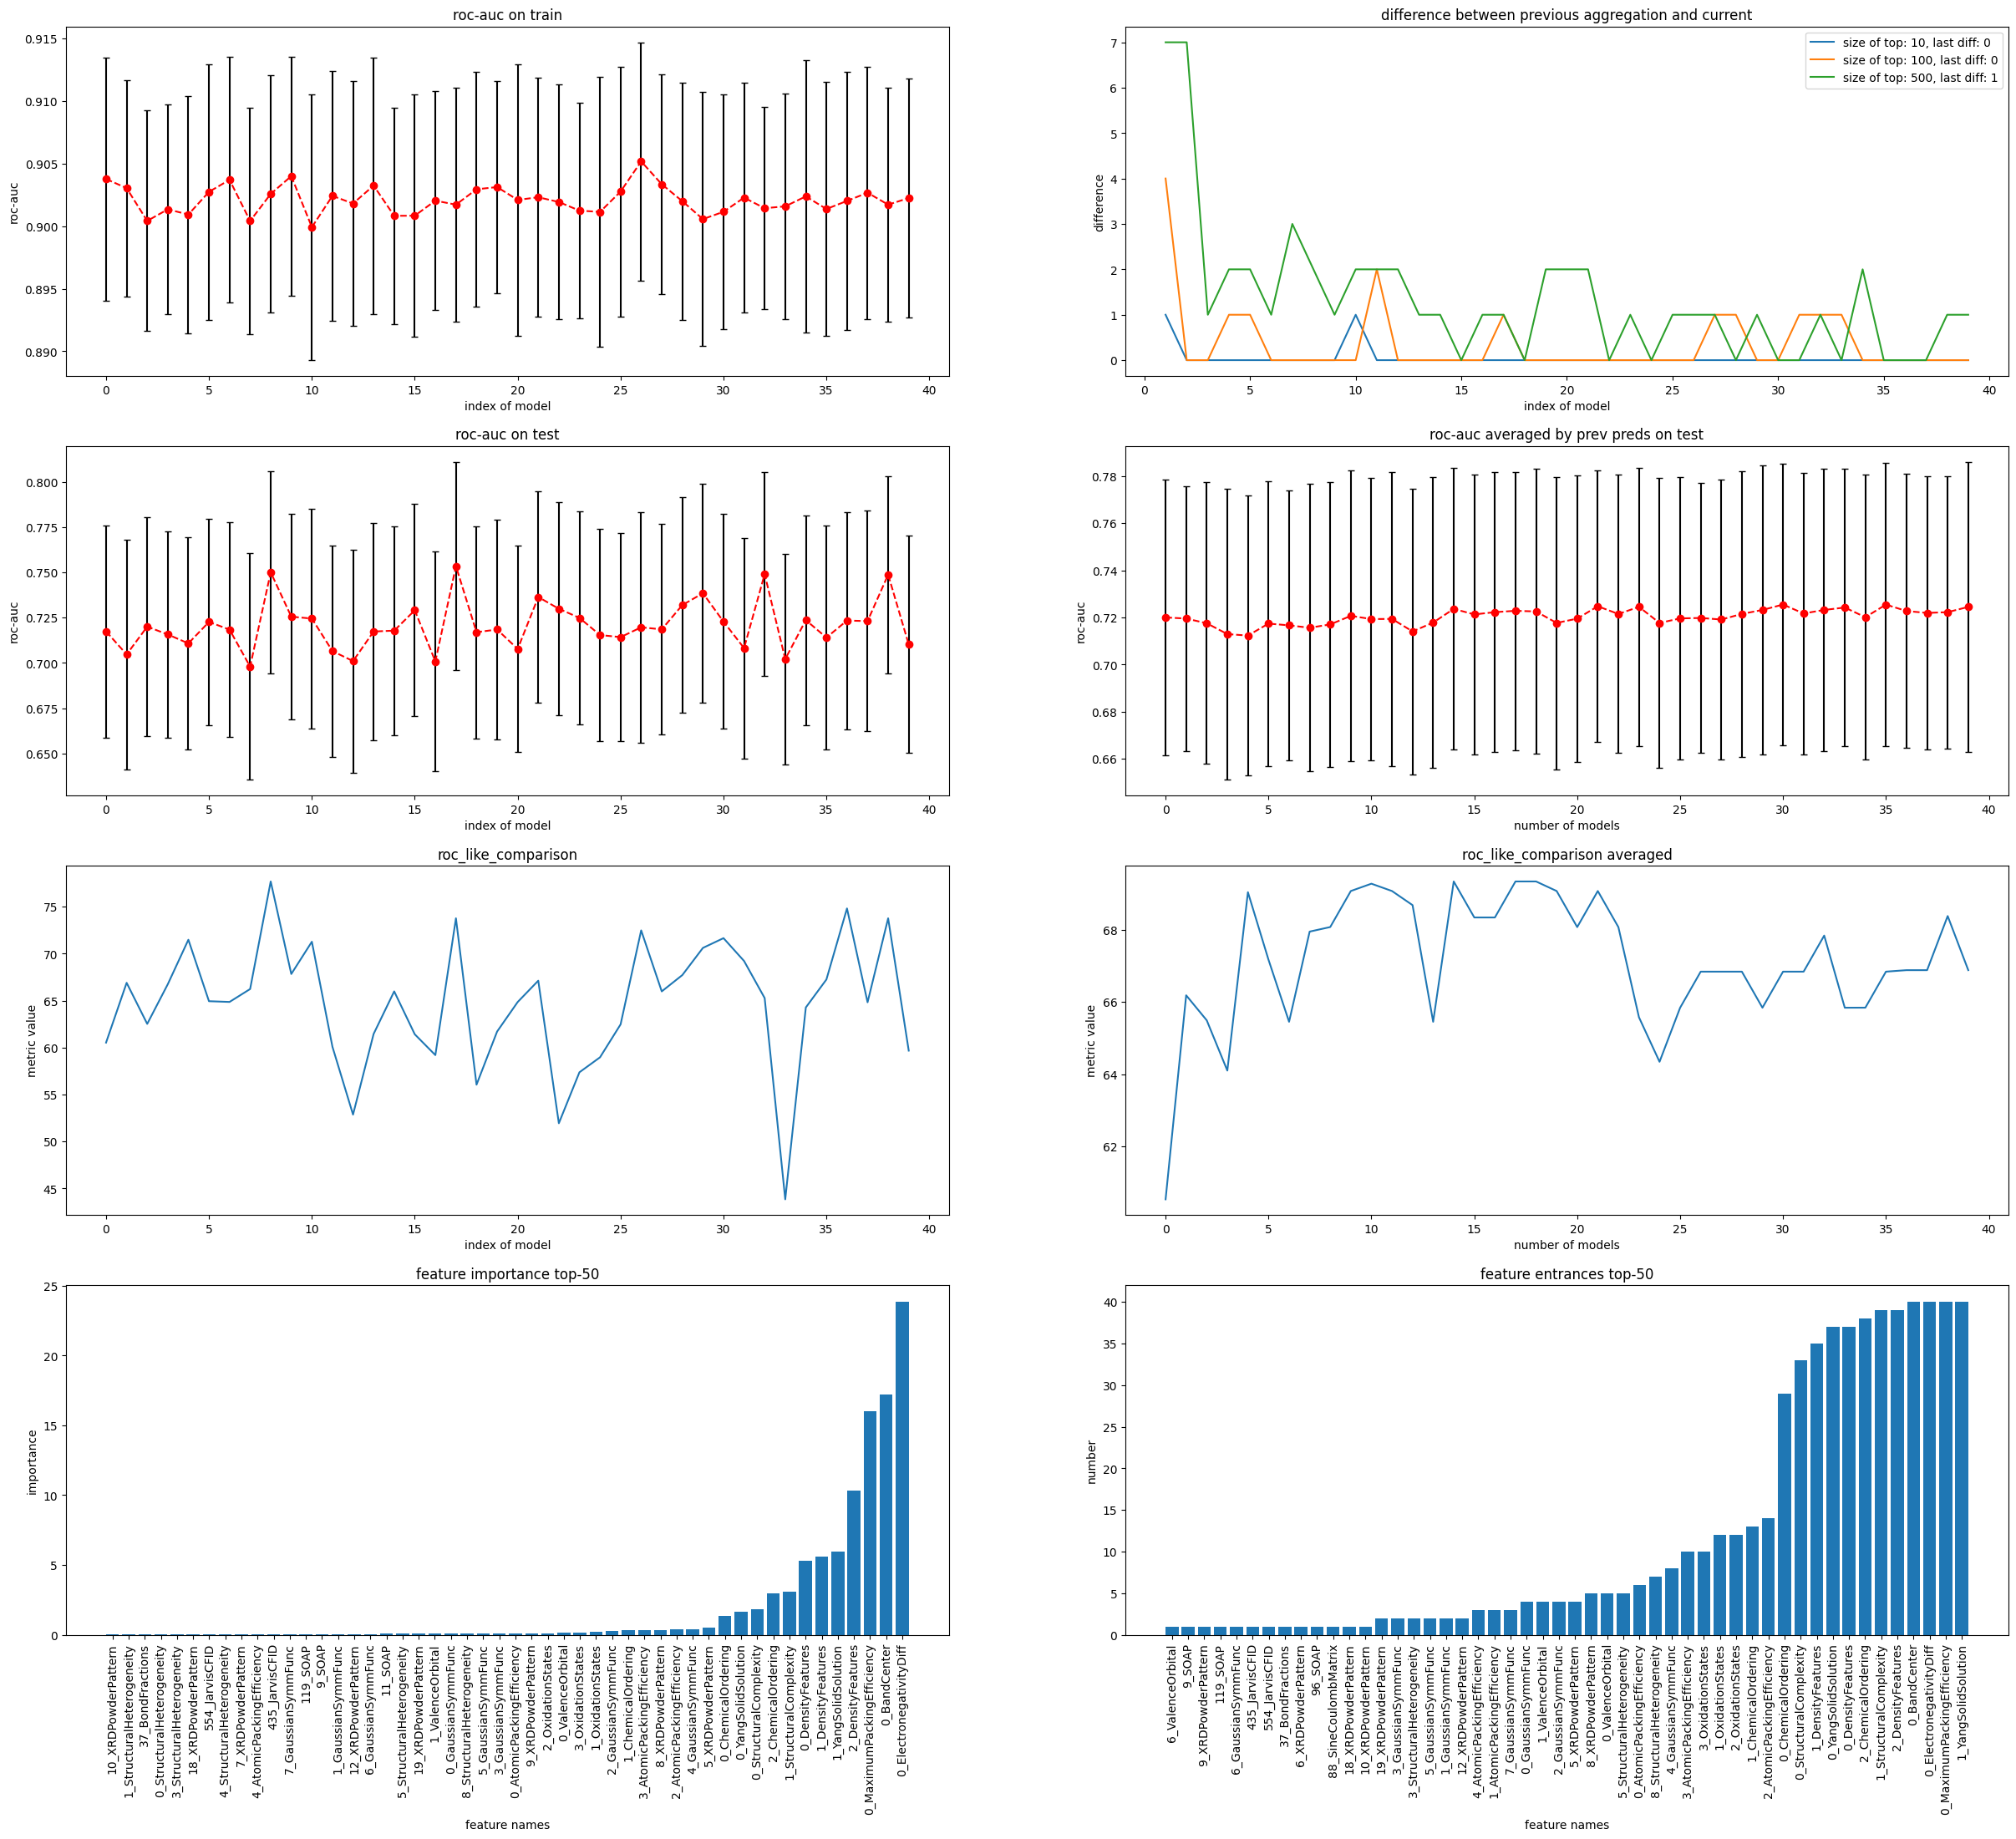

In [26]:
pipeline_catboost.plot_statistics()

In [27]:
preds_catboost_kahle = pipeline_catboost.preds_kahle_averaged[-1]
preds_catboost_mpdb = pipeline_catboost.preds_mpdb_averaged[-1]
preds_catboost_exp = pipeline_catboost.preds_exp_averaged[-1]

np.save('predictions/merged_catboost_kahle.npy', preds_catboost_kahle)
np.save('predictions/merged_catboost_mpdb.npy', preds_catboost_mpdb)
np.save('predictions/merged_catboost_exp.npy', preds_catboost_exp)


In [17]:
preds_logreg_l1_kahle = pipeline_logreg_l1.preds_kahle_averaged[-1]
preds_logreg_l1_exp = pipeline_logreg_l1.preds_mpdb_averaged[-1]

preds_logreg_l2_kahle = pipeline_logreg_l2.preds_kahle_averaged[-1]
preds_logreg_l2_exp = pipeline_logreg_l2.preds_mpdb_averaged[-1]

preds_catboost_kahle = pipeline_catboost.preds_kahle_averaged[-1]
preds_catboost_exp = pipeline_catboost.preds_mpdb_averaged[-1]

In [18]:
np.save('predictions/merged_logreg_l2_kahle.npy', preds_logreg_l2_kahle)
np.save('predictions/merged_logreg_l2_exp.npy', preds_logreg_l2_exp)

np.save('predictions/merged_logreg_l1_kahle.npy', preds_logreg_l1_kahle)
np.save('predictions/merged_logreg_l1_exp.npy', preds_logreg_l1_exp)

# np.save('predictions/merged_catboost_kahle.npy', preds_catboost_kahle)
# np.save('predictions/merged_catboost_exp.npy', preds_catboost_exp)

In [ ]:
from misc_utils import augment_Kahle2020

df_Kahle2020 = augment_Kahle2020.read_and_augment(
    "data_slim.csv",
)

preds_Kahle2020 = join_data_and_preds_Kahle2020(
    df_preds=pd.read_csv("datasets/exported.predictions.Kahle2020.v2.csv"),
    df_data=df_Kahle2020,
)

2024-09-03 23:28:26.443530: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-03 23:28:27.395129: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Estimating lognorm D parameters


Making initial guess:   0%|          | 0/195 [00:00<?, ?it/s]

2024-09-03 23:28:39.507451: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21487 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:06:00.0, compute capability: 8.6
2024-09-03 23:28:39.508048: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9280 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:0a:00.0, compute capability: 7.5
2024-09-03 23:28:39.508527: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 10108 MB memory:  -> device: 2, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1


refining:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
from misc_utils.feature_analysis import (
    get_features_meta_info, plot_features_Kahle2020, PairwiseComparisonMetrics, ROClikeComparisonMetrics,
    plot_feature_roclikes, add_feature, add_feature_np
)

In [ ]:
preds_catboost_kahle = pipeline_catboost.preds_kahle_averaged[-1]
preds_catboost_exp = pipeline_catboost.preds_mpdb_averaged[-1]


preds_logreg_kahle = pipeline_logreg.preds_kahle_averaged[-1]
preds_logreg_exp = pipeline_logreg.preds_mpdb_averaged[-1]


In [ ]:
np.save('predictions/nn_logreg_kahle.npy', preds_logreg_kahle)
np.save('predictions/nn_logreg_exp.npy', preds_logreg_exp)

np.save('predictions/nn_catboost_kahle.npy', preds_catboost_kahle)
np.save('predictions/nn_catboost_exp.npy', preds_catboost_exp)

In [ ]:
all_features = get_features_meta_info(masking_options=("",))

[preds_Kahle2020, preds_mp_exp], all_features = add_feature_np(
    [preds_Kahle2020, preds_mp_exp],
    all_features,
    values = [preds_catboost_kahle, preds_catboost_exp],
    name = "nn_catboost",
    type = "nn_catboost",
    level=0.0,
)


[preds_Kahle2020, preds_mp_exp], all_features = add_feature_np(
    [preds_Kahle2020, preds_mp_exp],
    all_features,
    values = [preds_logreg_kahle, preds_logreg_exp],
    name = "nn_logreg",
    type = "nn_logreg",
    level=0.0,
)

sigmoid = lambda x, steepness=10: 1.0 / (1.0 + np.exp(-x * steepness))

[preds_Kahle2020, preds_mp_exp], all_features = add_feature(
    [preds_Kahle2020, preds_mp_exp],
    all_features,
    func=lambda x: (
        sigmoid(np.log10(x["fv_0p5_connected_union"]) + 2.00)
        * sigmoid(np.log10(x["fv_0p5_disconnected_union"]) + 1.15)
    ),
    name="manual_combination",
    type="manual_combination",
    level=0.0,
)

[preds_Kahle2020, preds_mp_exp], all_features = add_feature(
    [preds_Kahle2020, preds_mp_exp],
    all_features,
    func=lambda x: (
        np.random.default_rng(42).uniform(0.01, 1.0, size=len(x))
    ),
    name="random_guess",
    type="random_guess",
    level=0.0,
)

In [ ]:
exp_pos = preds_mp_exp.query(
    "sigma_S_cm.replace('<1E-10', '1e-10').astype('float') >= 5e-5"
)["sample_weight"].sum()
exp_neg = preds_mp_exp.query(
    "sigma_S_cm.replace('<1E-10', '1e-10').astype('float') <= 1e-5"
)["sample_weight"].sum()


sim_pos = len(preds_Kahle2020.query("log10condNE300 >= -2.5"))
sim_pos_base = len(preds_Kahle2020.query("condNE1000 >= 0.1"))
sim_neg = len(preds_Kahle2020.query("condNE1000 <= 1e-2"))

print(f"exp          p/n: {exp_pos:.0f} / {exp_neg:.0f} = {exp_pos / exp_neg:.3f}")
print(f"sim (base)   p/n: {sim_pos_base:.0f} / {sim_neg:.0f} = {sim_pos_base / sim_neg:.3f}")
print(f"sim (extrap) p/n: {sim_pos:.0f} / {sim_neg:.0f} = {sim_pos / sim_neg:.3f}")


exp          p/n: 6 / 76 = 0.079
sim (base)   p/n: 31 / 64 = 0.484
sim (extrap) p/n: 4 / 64 = 0.062


In [ ]:
roclike_metrics = ROClikeComparisonMetrics()

feature_scores_experimental = roclike_metrics.eval_features(
    preds_df=preds_mp_exp,
    features_meta_info=all_features,
    positive_thr=5e-5,
    negative_thr=1e-5,
    weight_validation_plots=False,
    dataset_type="experimental",
    experimental_error_relative=1.0,
    num_bootstrap_samples=1000,
    num_negatives_max=0.1 * exp_neg,
)

feature_scores_base = roclike_metrics.eval_features(
    preds_df=preds_Kahle2020,
    features_meta_info=all_features,
    num_bootstrap_samples=1000,
    num_negatives_max=0.1 * sim_neg,
    positive_on_extrap300=False,
    weight_validation_plots=False,
)

feature_scores_extrap300 = roclike_metrics.eval_features(
    preds_df=preds_Kahle2020,
    features_meta_info=all_features,
    num_bootstrap_samples=1000,
    # num_negatives_max=2.0,
    num_negatives_max=0.1 * sim_neg,
    positive_on_extrap300=True,
    positive_thr=-2.5,
    weight_validation_plots=False,
)


Found sample weights!


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
all_features

,level,type,weighted_direction
feature,,,
barrier,0.00,barrier,-1.0
barrier_robust_0p03,0.03,barrier,-1.0
barrier_robust_0p05,0.05,barrier,-1.0
barrier_robust_0p10,0.10,barrier,-1.0
fv_0p1_connected_union,0.10,fv_connected,1.0
fv_0p2_connected_union,0.20,fv_connected,1.0
fv_0p3_connected_union,0.30,fv_connected,1.0
fv_0p4_connected_union,0.40,fv_connected,1.0
fv_0p5_connected_union,0.50,fv_connected,1.0


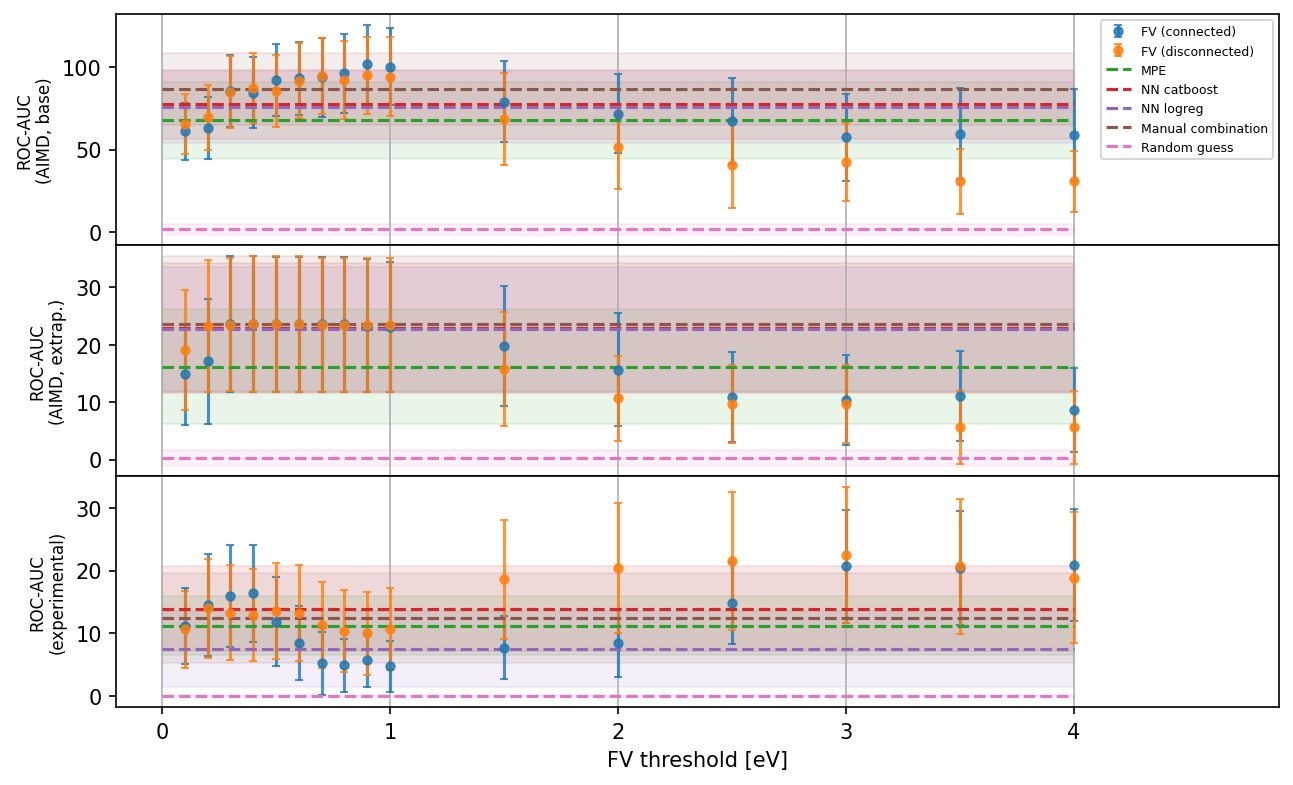

In [ ]:
from pathlib import Path
out_path = Path("fv.analysis.2.3_finilizingPlots")
if not out_path.exists():
    out_path.mkdir()
    
fig = plt.figure(figsize=(10, 6), dpi=150)

label_map = dict(
    fv_connected="FV (connected)",
    fv_disconnected="FV (disconnected)",
    barrier="MPE",
    nn_catboost = "NN catboost",
    nn_logreg = "NN logreg",
    manual_combination="Manual combination",
    random_guess="Random guess",
)

for i_plt, (score_type, score_vals, score_errs) in enumerate([
    ("ROC-AUC\n(AIMD, base)", feature_scores_base["score"], (feature_scores_base["score_bs_q84"] - feature_scores_base["score_bs_q16"]) / 2),
    ("ROC-AUC\n(AIMD, extrap.)", feature_scores_extrap300["score"], (feature_scores_extrap300["score_bs_q84"] - feature_scores_extrap300["score_bs_q16"]) / 2),
    ("ROC-AUC\n(experimental)", feature_scores_experimental["score"], (feature_scores_experimental["score_bs_q84"] - feature_scores_experimental["score_bs_q16"]) / 2),
], 1):
    plt.subplot(3, 1, i_plt, sharex=None if i_plt == 1 else plt.gca())
    groups = {t: g for t, g in all_features.groupby("type")}
    for t in label_map.keys():
        g = groups[t]
        if "fv" in t:
            plt.errorbar(
                g["level"], score_vals.loc[g.index], yerr=score_errs.loc[g.index],
                label=label_map[t], fmt="o", capsize=2.0, alpha=0.8, ms=4.0,
            )
        else:
            yval = score_vals.loc[g.index].iloc[0]
            yerr = score_errs.loc[g.index].iloc[0]
            (l,) = plt.plot([0.0, 4.0], [yval] * 2, '--', label=label_map[t])
            plt.fill_between([0.0, 4.0,], [yval + yerr] * 2, [yval - yerr] * 2, color=l.get_color(), alpha=0.1)
    if i_plt == 1:
        handles, labels = plt.gca().get_legend_handles_labels()
        lh_dict = {l: h for l, h in zip(labels, handles)}
        labels = list(label_map.values())
        handles = [lh_dict[l] for l in labels]
        plt.legend(handles, labels, fontsize=6)
    plt.grid(axis='x', visible=True)
    plt.ylabel(score_type, fontsize=8)
    plt.xlim(-0.2, 4.9)
plt.xlabel("FV threshold [eV]")

fig.subplots_adjust(hspace=0)
fig.savefig(out_path / "feature_evaluation.pdf")